## Проект: Прогнозирование вероятности открытия срочного депозита в банке

### Задание и краткая информация
* Данные связаны с кампаниями прямого маркетинга (телефонными звонками) португальского банковского учреждения
* Цель классификации — предсказать, подпишется ли клиент на срочный депозит (переменная y)
* На основе этой информации можно строить более эффектиыную маркетинговую кампанию
* Датасет взят из открытых источников. Информация о принадлежности данных ниже (Data citation information)

### Data citation information:
This dataset is public available for research. The details are described in [Moro et al., 2014].

- `Source of data:` 
[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

- `via UC Irvine Machine Learning Repository https://archive.ics.uci.edu/ml/datasets/Bank+Marketing`


S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology.

In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães,

Portugal, October, 2011. EUROSIS.

## Описание данных

### Input variables:
#### bank client data:
- `age` (numeric)
- `job` : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- `marital` : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- `education` (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- `default`: has credit in default? (categorical: 'no','yes','unknown')
- `balance`: average yearly balance, in EUR (numeric)
- `housing`: has housing loan? (categorical: 'no','yes','unknown')
- `loan`: has personal loan? (categorical: 'no','yes','unknown')

#### related with the last contact of the current campaign:
- `contact`: contact communication type (categorical: 'cellular','telephone')
- `day`: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- `month`: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- `duration`: last contact duration, in seconds (numeric). 
Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). 
Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. 
Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

#### other attributes:
- `campaign`: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- `pdays`: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- `previous`: number of contacts performed before this campaign and for this client (numeric)
- `poutcome`: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')


#### Output variable (desired target):
- `y` - has the client subscribed a term deposit? (binary: 'yes','no')

## Структура проекта (декомпозиция задачи)

### 1. [Исследовательский анализ данных (EDA)](#analysis)
   * [1.1. Загрузка и первичная обработка данных
     (дубликаты, пропущенные значения, структуры и типы данных и т.п.)](#analysis1)
   * [1.2. EDA: исследование распределений числовых/категориальных признаков, корреляционный анализ](#analysis2)
  
### 2. [Построение и тренировка моделей](#model)
   * [2.1. Обработка данных для построения моделей](#model1)
   
   * [2.2.  Подбор параметров и тренировка модели CatBoostClassifier](#model2)
   
   * [2.3. Дополнительная обработка данных для построения моделей](#model3)
   
   * [2.4. Подбор параметров и тренировка модели RandomForestClassifier](#model4)
   
   * [2.5. Подбор параметров и тренировка модели DecisionTreeClassifier](#model5)
   
   * [2.6. Построение и тренировка модели Keras Sequential](#model6)
   
   * [2.7. Построение и тренировка модели Keras Sequential with Cross-validation](#model7)

### 3. [Выводы и сохранение лучшей модели](#conclusion)

<a id="analysis"></a>
## 1. Исследовательский анализ данных (EDA)

<a id="analysis1"></a>
### 1.1. Загрузка и первичная обработка данных 

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.utils import shuffle
from plot_metric.functions import BinaryClassification
import itertools
from pandas_profiling import ProfileReport
from sklearn.cluster import KMeans
import tensorflow as tensorflow
from keras import metrics
import pickle
import sweetviz as sw
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import cross_val_score, GridSearchCV 
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,\
                            precision_recall_curve, roc_curve, classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# снимем ограничение на кол-во и ширину столбцов
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [3]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [4]:
# Загрузим данные с внешнего диска
url="https://getfile.dokpub.com/yandex/get/https://disk.yandex.com/i/r_ap-UbIMfAwgA"
bank=pd.read_csv(url, sep=';')

In [5]:
bank.iloc[:, 1:].describe()

,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [68]:
#profile = ProfileReport(bank)
#profile

In [7]:
#repo=sw.analyze(bank)
#repo.show_html('output.html', open_browser=True)

In [8]:
bank['marital']= bank['marital'].map({'divorced': 'single', 'single': 'single', 'married': 'married'})
bank['job']= bank['job'].map({'entrepreneur': 'self-employed','management': 'management',
                              'technician':'technician', 'blue-collar':'blue-collar',
                              'unknown':'unknown', 'retired':'retired', 'admin.':'management',
                              'services':'services', 'self-employed':'self-employed',
                              'unemployed':'unemployed', 'housemaid':'housemaid', 'student':'student'})

In [9]:
bank[['job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'day', 'month', 'campaign', 'pdays',
       'previous', 'poutcome']].astype("category")
bank.dtypes

age          int64 
job          object
marital      object
education    object
default      object
balance      int64 
housing      object
loan         object
contact      object
day          int64 
month        object
duration     int64 
campaign     int64 
pdays        int64 
previous     int64 
poutcome     object
y            object
dtype: object

In [10]:
encoder = LabelEncoder()
bank['y'] = encoder.fit_transform(bank['y'])
y = {index : label for index, label in enumerate(encoder.classes_)}

<a id="analysis2"></a>
### 1.2. EDA: исследование распределений числовых/категориальных признаков, корреляционный анализ

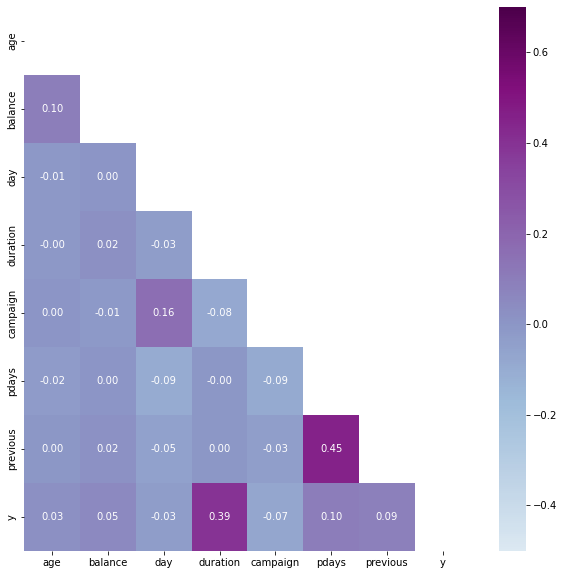

In [11]:
plt.figure(figsize=(10,10))
corr_matrix = bank.corr()
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))
sns.heatmap(lower, annot=True, cmap="BuPu",fmt='.2f', cbar=True, center=0,\
           vmin=-0.5, vmax=0.7, linecolor='white');

<Figure size 720x720 with 0 Axes>

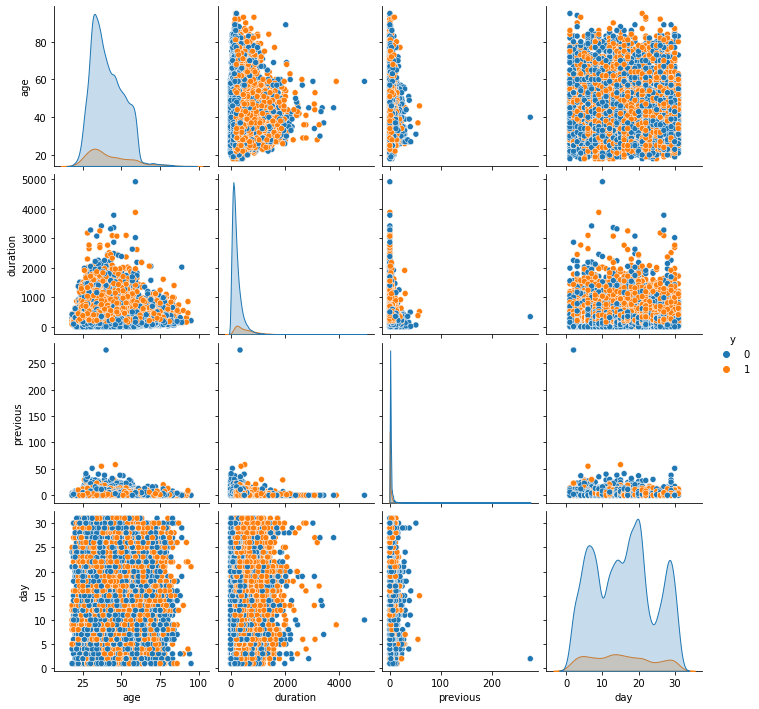

In [12]:
plt.figure(figsize=(10,10))
sns.pairplot(data=bank,vars=('age','duration','previous','day'), hue='y', height=2.5);

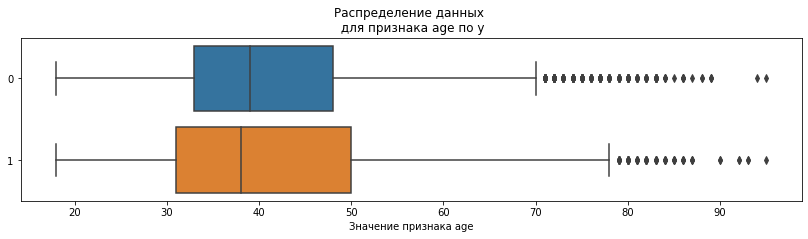

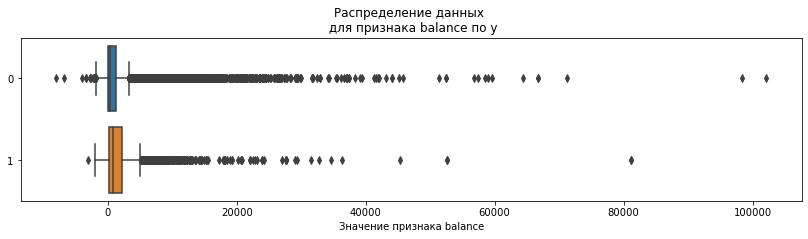

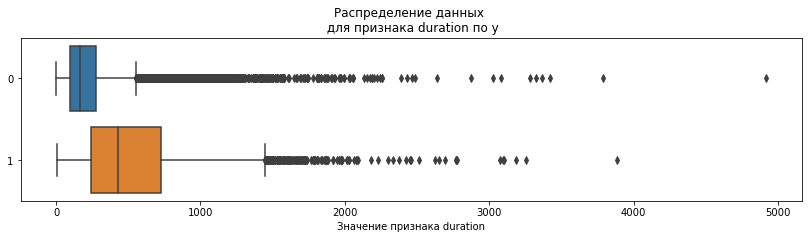

In [13]:
for column in bank.drop(columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'day', 'month', 'campaign', 'pdays', 'previous', 'poutcome','y']).columns:
    fig,ax = plt.subplots(figsize=(14,3))
    ax=sns.boxplot(x=bank[column], y=bank.y, ax=ax, saturation=0.7,orient='h')
    plt.title('Распределение данных \n для признака '+ str(column) + ' по y')
    plt.xlabel('Значение признака ' + column)
    plt.ylabel('')
    plt.show()

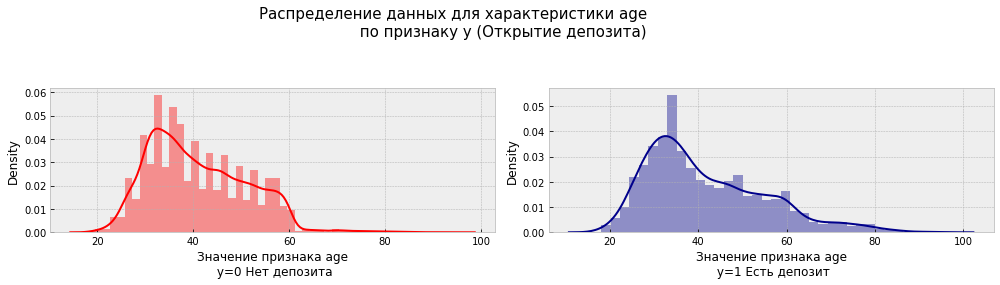

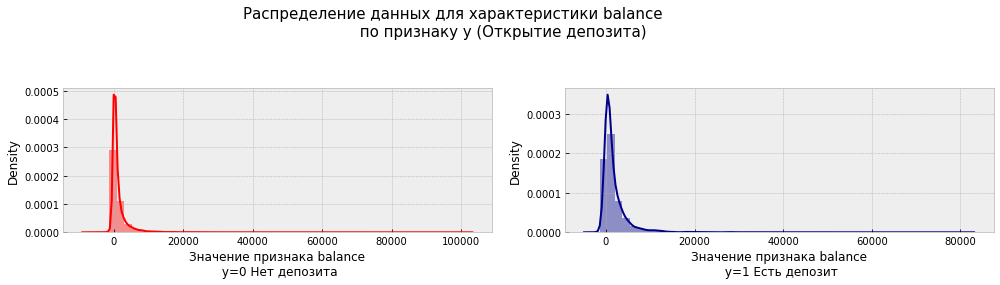

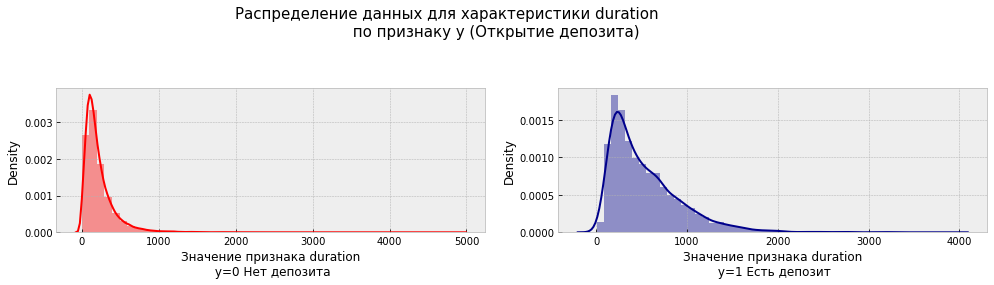

In [14]:
plt.style.use('bmh')
for column in bank.drop(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'day', 'month', 'campaign', 'pdays', 'previous', 'poutcome','y'],axis=1).columns:
    fig, ax = plt.subplots(1,2, figsize = (14,4),  tight_layout=True, sharey=False, sharex=False)
    sns.distplot(bank.query('y == 0')[column].dropna(), hist=True, color='red',ax = ax[0], norm_hist = True)
    sns.distplot(bank.query('y == 1')[column].dropna(), hist=True, color='darkblue',ax = ax[1], norm_hist = True)
    ax[0].set_title(' \n')
    ax[1].set_title(' \n')
    ax[0].set_xlabel('Значение признака '+ str(column)+ '\n y=0 Нет депозита')
    ax[1].set_xlabel('Значение признака '+ str(column)+ '\n y=1 Есть депозит')
    plt.suptitle('Распределение данных для характеристики ' + column + '\
                    '   + '\n по признаку y (Открытие депозита)', fontsize=15)
    plt.show()

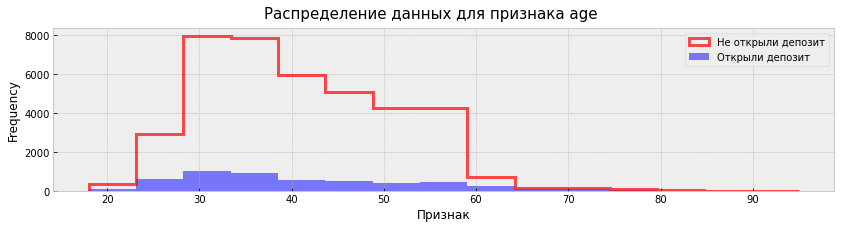

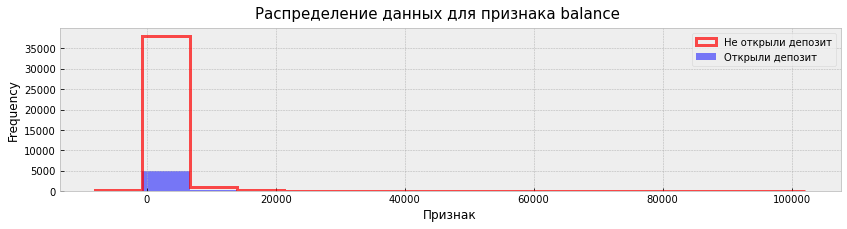

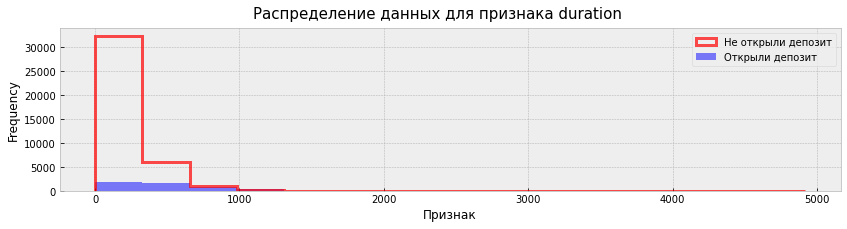

In [15]:
# Визуализируем наложением двух выборок друг на друга по признаку y (депозит), без нормализации (density=False)
for column in bank.drop(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'day', 'month', 'campaign', 'pdays', 'previous', 'poutcome','y'],axis=1).columns:
    hist_range=(bank[column].min(), bank[column].max())
    bins=bank[column].nunique()
    ax = bank.query('y == 0').plot(kind='hist', y=column, histtype='step',\
                                   figsize = (14,3), density=False, range=hist_range, bins=15,\
                                   linewidth=3, alpha=0.7, label='Не открыли депозит', color='r')
    bank.query('y == 1').plot(kind='hist', y=column,figsize = (14,3), histtype='stepfilled',\
                              density=False, range= hist_range, bins=15, linewidth=2, alpha=0.5,\
                              label='Открыли депозит', ax=ax, color='b', grid=True, legend=True)
    plt.xlabel('Признак')
    plt.suptitle('Распределение данных для признака '+ str(column), fontsize=15)
    plt.show()

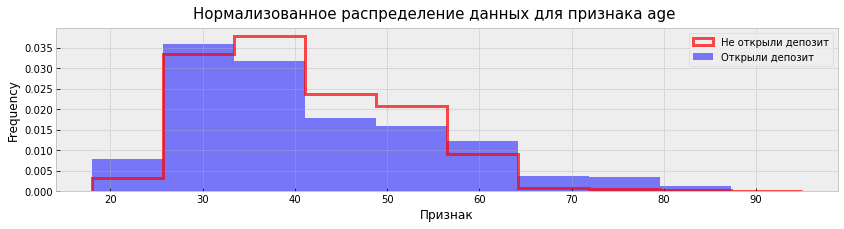

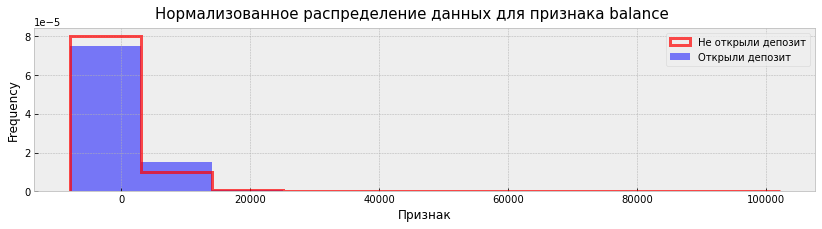

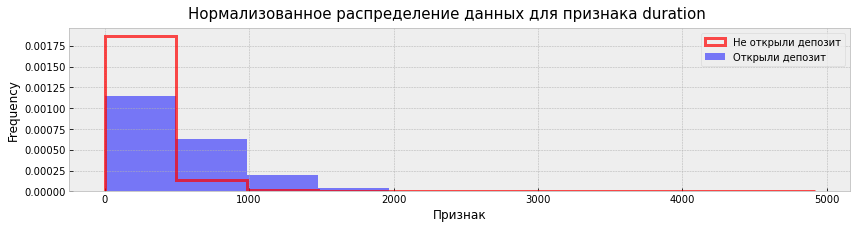

In [16]:
# Визуализируем наложением двух выборок друг на друга по признаку y (депозит), с нормализацией ( density=True)
for column in bank.drop(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'day', 'month', 'campaign', 'pdays', 'previous', 'poutcome','y'],axis=1).columns:
    hist_range=(bank[column].min(), bank[column].max())
    ax = bank.query('y == 0').plot(kind='hist', y=column, histtype='step',\
                                   figsize = (14,3), density=True, range=hist_range,\
                                   bins=10, linewidth=3, alpha=0.7, label='Не открыли депозит', color='r')
    bins=bank[column].nunique()
    bank.query('y == 1').plot(kind='hist', y=column,figsize = (14,3),\
                              histtype='stepfilled', density=True, range= hist_range,\
                              bins=10, linewidth=2, alpha=0.5, label='Открыли депозит', ax=ax,\
                              color='b', grid=True, legend=True)
    plt.xlabel('Признак')
    plt.suptitle('Нормализованное распределение данных для признака '+ str(column), fontsize=15)
    #bins=df[column].nunique()
    plt.show()

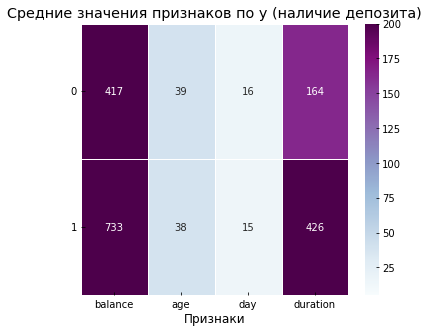

In [17]:
# Посмотрим на некоторые признаки в разбивке по y (депозит)
plt.figure(figsize = (6,5))
sns.heatmap(data=bank.groupby(['y'])['balance','age', 'day', 'month', 'duration']\
            .median().round(1).sort_values(by='y'), annot = True, vmin=5, vmax=200\
            ,linewidths=1, linecolor='white',cmap="BuPu", fmt='.0f', annot_kws={"size": 10})
plt.xticks(rotation=0) 
plt.yticks(rotation=0)
plt.title('Средние значения признаков по y (наличие депозита)')
plt.ylabel('')
plt.xlabel('Признаки')
plt.show()

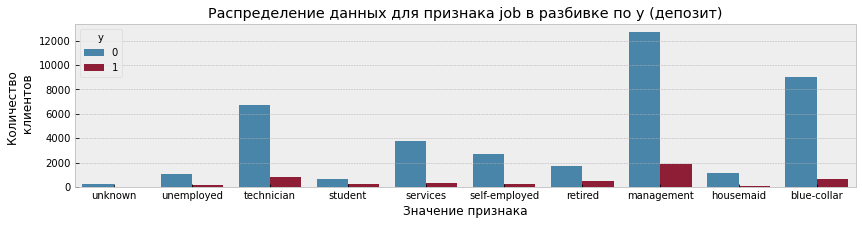

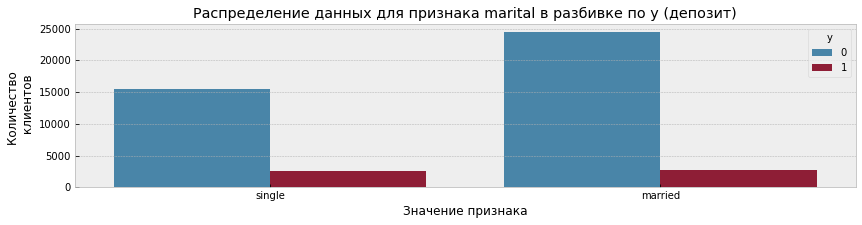

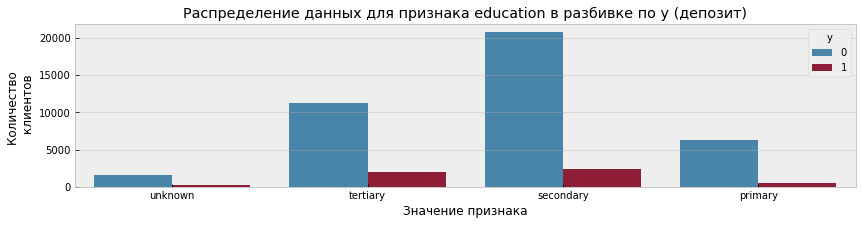

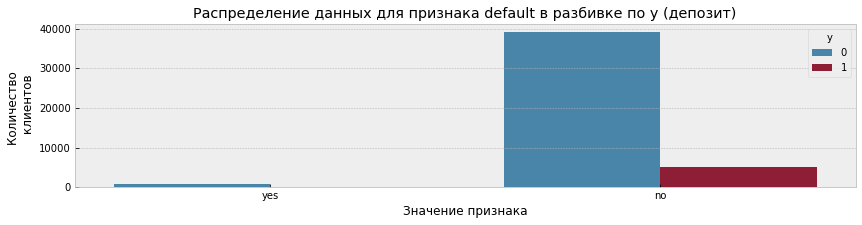

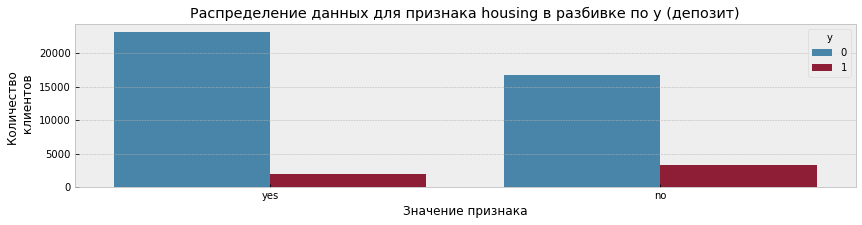

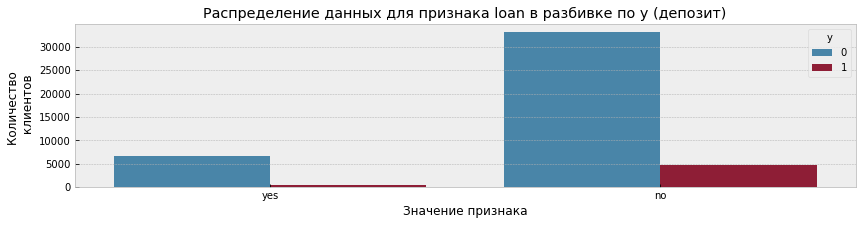

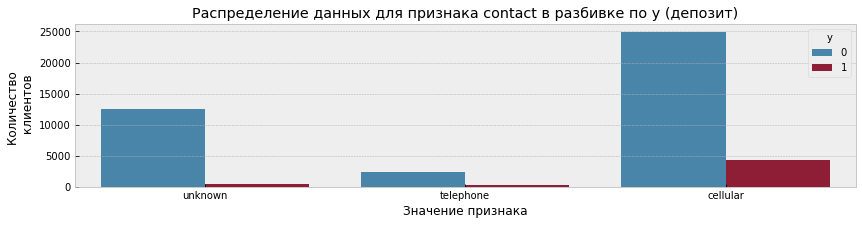

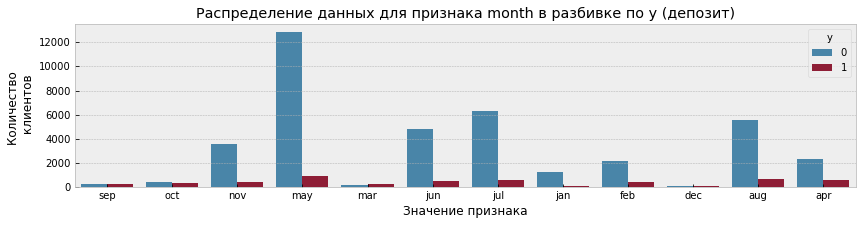

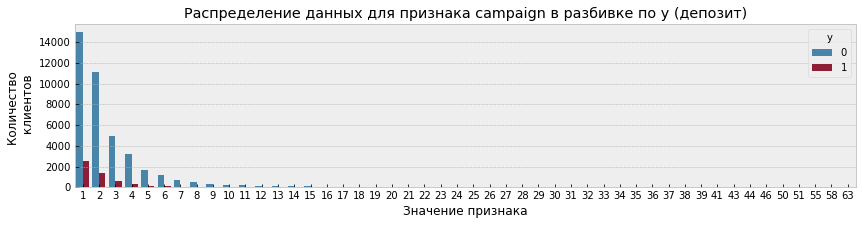

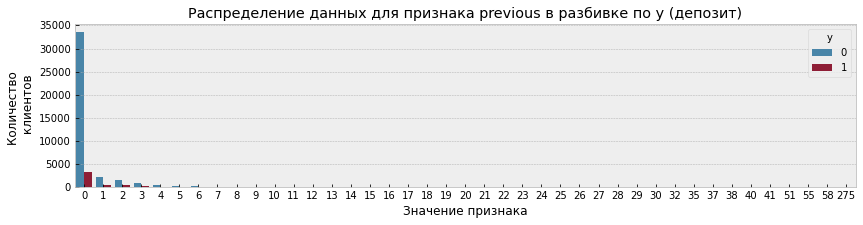

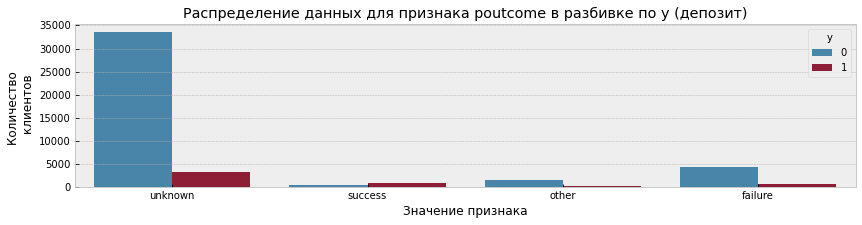

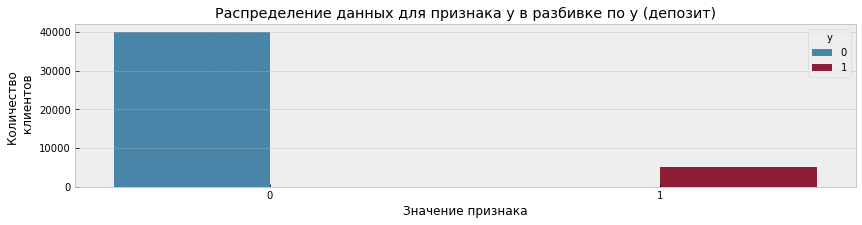

In [18]:
# Сбросим ненужные столбцы и построим с помощью countplot
for column in bank.drop(columns=['balance','age', 'day', 'duration', 'pdays']).columns:
    fig, ax = plt.subplots(figsize=(14,3))
    sns.countplot(x=column, hue='y',data=bank.sort_values(by=column,\
                                    ascending=False), ax=ax, saturation=0.7)
    plt.title('Распределение данных для признака '+ str(column) + ' в разбивке по y (депозит)')
    plt.ylabel('Количество \n клиентов')
    plt.xlabel('Значение признака')
    plt.show()

<a id="model"></a>
## 2. Построение и тренировка моделей

<a id="model1"></a>
### 2.1. Обработка данных для построения моделей

In [19]:
x = bank.drop(columns=['y'], axis=1)
y = bank['y']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,  stratify = bank['y'], shuffle=True)

In [20]:
print("x_train shape is",x_train.shape)
print("y_train shape is",y_train.shape)

print("x_test shape is ",x_test.shape)
print("y_test shape is",y_test.shape)

x_train shape is (36168, 16)
y_train shape is (36168,)
x_test shape is  (9043, 16)
y_test shape is (9043,)


In [21]:
numeric = ['age','balance', 'duration']

scaler = StandardScaler()
scaler.fit(x_train[numeric])
x_train[numeric] = scaler.transform(x_train[numeric])

x_test = x_test.iloc[:-1,:]
x_test[numeric] = scaler.transform(x_test[numeric])

<a id="model2"></a>
### 2.2. Подбор параметров и тренировка модели CatBoostClassifier

In [22]:
#x_train.columns

In [23]:
cat_features = ['job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'day', 'month', 'campaign', 'pdays',
       'previous', 'poutcome']

In [24]:
#%%time
#model_cb = CatBoostClassifier(random_seed=42, verbose =10, cat_features = cat_features, auto_class_weights='SqrtBalanced')
#                              
#scorer = make_scorer(accuracy_score)
#params = {'depth': (4,6,8),
#          'learning_rate' : [0.01,0.05],
#          'iterations'    : [100,250,500],
#          #'leaf_estimation_iterations': [4],
#          #'eval_metric': ['F1', 'AUC'] 
#          'custom_metric' : ['TotalF1','Recall','Precision', 'AUC']
#         }
#grid = GridSearchCV(estimator=model_cb, param_grid = params,\
#                    #scoring= custom_metric,\
#                    cv = 5, n_jobs=-1, verbose =2)
#grid.fit(x_train, y_train, cat_features = cat_features)
#print(" Results from Grid Search ")
#print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
#print("\n The best score across ALL searched params:\n", grid.best_score_)
#print("\n The best parameters across ALL searched params:\n", grid.best_params_)    

#Results from Grid Search 
#
# The best estimator across ALL searched params:
# <catboost.core.CatBoostClassifier object at 0x0000017B9A455B20>
#
# The best score across ALL searched params:
# 0.9124641571337648
#
# The best parameters across ALL searched params:
# {'depth': 6, 'eval_metric': 'AUC', 'learning_rate': 0.01}

In [25]:
custom_metric = ['TotalF1','F1', 'Precision', 'Recall', 'AUC']

bestTest = 0.281295151
bestIteration = 247

#Shrink model to first 248 iterations.
{'learn': {'Logloss': 0.20636632432184968, 
           'Precision:use_weights=false': 0.6388790976383504,
           'Precision:use_weights=true': 0.8293695692528662,
           'TotalF1:use_weights=false': 0.9310964872792754,
           'TotalF1:use_weights=true': 0.9152212693275119},
 'validation': {'Logloss': 0.2812951509949547,
                'Precision:use_weights=false': 0.559774964838256,
                'Precision:use_weights=true': 0.7774577375863717,
                'TotalF1:use_weights=false': 0.9080972621498083,
                'AUC': 0.9363909766603149,
                'TotalF1:use_weights=true': 0.8774603822205642}}
                
                
bestTest = 0.1942920838
bestIteration = 360

#Shrink model to first 361 iterations.
{'learn': {'Logloss': 0.14821912110952992,
           'TotalF1': 0.9412263539657855,
           'Precision': 0.8353012412957918},
 'validation': {'Logloss': 0.1942920838258018,
                'TotalF1': 0.9057702706729909,
                'AUC': 0.9355889235938797,
                'Precision': 0.6946107784431138}}

{'learn': {'Logloss': 0.14821912110952992,
  'TotalF1': 0.9412263539657855,
  'Precision': 0.8353012412957918},
 'validation': {'Logloss': 0.1942920838258018,
  'TotalF1': 0.9057702706729909,
  'AUC': 0.9355889235938797,
  'Precision': 0.6946107784431138}}

In [26]:
model_cb = CatBoostClassifier(verbose=100, iterations=500, \
                              custom_metric = ['TotalF1'],\
                              auto_class_weights='SqrtBalanced',
                              depth = 8, learning_rate =0.05,\
                              cat_features=cat_features, random_seed=42)

model_cb.fit(x_train,y_train,eval_set=(x_test,y_test[:-1]),\
             cat_features=cat_features, use_best_model=True, plot=True)

print(model_cb.get_best_score())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6399733	test: 0.6401624	best: 0.6401624 (0)	total: 226ms	remaining: 1m 52s
100:	learn: 0.2589625	test: 0.2861033	best: 0.2861033 (100)	total: 12.9s	remaining: 50.8s
200:	learn: 0.2386765	test: 0.2816987	best: 0.2816703 (199)	total: 23.2s	remaining: 34.5s
300:	learn: 0.2222999	test: 0.2816757	best: 0.2812952 (247)	total: 35.3s	remaining: 23.3s
400:	learn: 0.2086887	test: 0.2820727	best: 0.2812952 (247)	total: 47.2s	remaining: 11.7s
499:	learn: 0.1964661	test: 0.2829403	best: 0.2812952 (247)	total: 58.8s	remaining: 0us

bestTest = 0.281295151
bestIteration = 247

Shrink model to first 248 iterations.
{'learn': {'Logloss': 0.19646606237517975, 'TotalF1:use_weights=false': 0.9355699215180732, 'TotalF1:use_weights=true': 0.9212912561808675}, 'validation': {'Logloss': 0.2812951509949547, 'TotalF1:use_weights=false': 0.9080972621498083, 'TotalF1:use_weights=true': 0.8774603822205642}}


In [27]:
# Проанализируем важность факторов
feature_importance_cb = pd.DataFrame({'feature_importance':model_cb.feature_importances_,\
                                   'feature_name': x_test.columns}).sort_values(by=['feature_importance'], 
                                    ascending=False)
feature_importance_cb.to_csv(index=False)
feature_importance_cb

,feature_importance,feature_name
11,38.499099,duration
8,13.675579,contact
10,12.630772,month
9,7.154521,day
5,3.887403,balance
15,3.627021,poutcome
3,3.401013,education
12,3.343645,campaign
6,3.322831,housing
0,2.718567,age


In [28]:
# Дополнительно рассчитаем такую метрику как `Accuracy`
predictions_cb = model_cb.predict(x_test)
probabilities_cb = model_cb.predict_proba(x_test)[:,1]
print('-------------------------------------------------------------------------------------')
print("Accuracy score модели CatBoostClassifier на тестовой выборке (balanced): {:.2f}"\
      .format(accuracy_score(y_test[:-1], predictions_cb)))

-------------------------------------------------------------------------------------
Accuracy score модели CatBoostClassifier на тестовой выборке (balanced): 0.90


  -------------------------------------------------
   Roc-Auc Score is: 0.936
  -------------------------------------------------


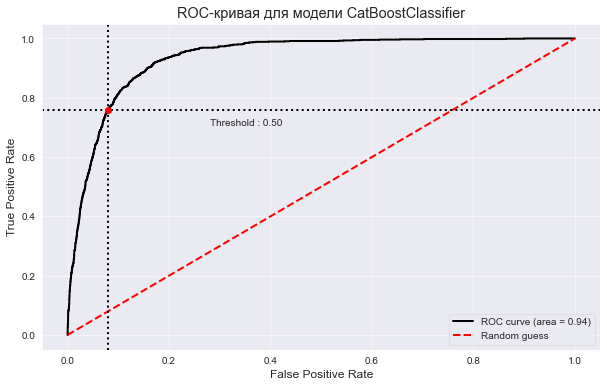

In [29]:
# Посмотрим на ROC-AUC в графическом представлении
bc = BinaryClassification(y_test[:-1], probabilities_cb, labels=["Class 1"])
print('  -------------------------------------------------')
print('   Roc-Auc Score is: {:.3f}'.format(roc_auc_score(y_test[:-1], probabilities_cb)))
print('  -------------------------------------------------')
plt.figure(figsize=(10,6))
bc.plot_roc_curve()
plt.title('ROC-кривая для модели CatBoostClassifier')
plt.show()

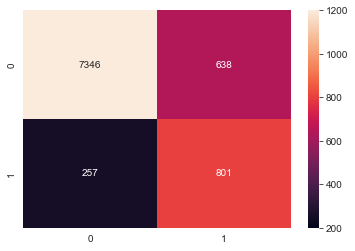

In [30]:
# Визуализируем матрицу ошибок построенной модели по классам
confusionMatrix = confusion_matrix(y_test[:-1],predictions_cb)
sns.heatmap(confusionMatrix,annot=True,fmt='d', vmin=200, vmax=1200,);

In [31]:
# Выведем основные метрики через `Сlassification_report`
print('----------------------------------------------------------------------------')
print('Сlassification_report по основным метрикам для модели CatBoostClassifier:')
print('-----------------------------------------------------------------------------')
print(classification_report(y_test[:-1],predictions_cb))
#F1Score_cb = f1_score(y_test, predictions_cb, average='micro') #it can be : binary,macro,weighted,samples
#print('F1 Score Micro for RF model is : ', F1Score_cb.round(3))

----------------------------------------------------------------------------
Сlassification_report по основным метрикам для модели CatBoostClassifier:
-----------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      7984
           1       0.56      0.76      0.64      1058

    accuracy                           0.90      9042
   macro avg       0.76      0.84      0.79      9042
weighted avg       0.92      0.90      0.91      9042



<a id="model3"></a>
### 2.3. Дополнительная обработка данных для построения моделей

In [32]:
bank['job'] = encoder.fit_transform(bank['job'])
job = {index : label for index, label in enumerate(encoder.classes_)}

bank['marital'] = encoder.fit_transform(bank['marital'])
marital = {index : label for index, label in enumerate(encoder.classes_)}

bank['education'] = encoder.fit_transform(bank['education'])
education = {index : label for index, label in enumerate(encoder.classes_)}

bank['default'] = encoder.fit_transform(bank['default'])
default = {index : label for index, label in enumerate(encoder.classes_)}

bank['loan'] = encoder.fit_transform(bank['loan'])
loan = {index : label for index, label in enumerate(encoder.classes_)}

bank['contact'] = encoder.fit_transform(bank['contact'])
contact = {index : label for index, label in enumerate(encoder.classes_)}

bank['month'] = encoder.fit_transform(bank['month'])
month = {index : label for index, label in enumerate(encoder.classes_)}

bank['poutcome'] = encoder.fit_transform(bank['poutcome'])
poutcome = {index : label for index, label in enumerate(encoder.classes_)}

bank['housing'] = encoder.fit_transform(bank['housing'])
housing = {index : label for index, label in enumerate(encoder.classes_)}

In [33]:
#encoder = LabelEncoder()
#bank['y'] = encoder.fit_transform(bank['y'])
#y = {index : label for index, label in enumerate(encoder.classes_)}

In [34]:
x = bank.drop('y', axis=1)
y = bank['y']

print(x.shape)
print(y.shape)

(45211, 16)
(45211,)


In [35]:
scaler1 = MinMaxScaler(copy=True, feature_range=(0, 1))
X = scaler1.fit_transform(x)
X.shape

(45211, 16)

In [36]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify = bank['y'])

print("X_train shape is",X_train.shape)
print("y_train shape is",y_train.shape)

print("X_test shape is ",X_test.shape)
print("y_test shape is",y_test.shape)

X_train shape is (36168, 16)
y_train shape is (36168,)
X_test shape is  (9043, 16)
y_test shape is (9043,)


<a id="mode4"></a>
### 2.4. Подбор параметров и тренировка модели RandomForestClassifier

In [37]:
#%%time
#model_rf = RandomForestClassifier(random_state=42, verbose =10,\
#                                  n_jobs = -1, class_weight='balanced_subsample',bootstrap=True)
#                              
#scorer = make_scorer(accuracy_score)
#params = {'max_depth': [10,12,20],
#          'n_estimators' : [100,200,400],
#          'criterion'    : ['gini', 'entropy'],
#          'max_features': ['auto', 'sqrt', 'log2']
#          #'leaf_estimation_iterations': [4],
#          #'eval_metric': ['F1', 'AUC'] 
#          #'custom_metric' : ['TotalF1','Recall','Precision', 'AUC']
#         }
#grid = GridSearchCV(estimator=model_rf, param_grid = params,\
#                    return_train_score='warn',\
#                    cv = 5, n_jobs=-1, verbose =2, refit=True)
#grid.fit(X_train, y_train)
##, cat_features = cat_features)
#print(" Results from Grid Search ")
#print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
#print("\n The best score across ALL searched params:\n", grid.best_score_)
#print("\n The best parameters across ALL searched params:\n", grid.best_params_)    
#
#Results from Grid Search
#
# The best estimator across ALL searched params:
# RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
#                       max_depth=20, max_features='auto', n_jobs=-1,
#                       random_state=42, verbose=10)
#
# The best score across ALL searched params:
# 0.9032017569459487
#
# The best parameters across ALL searched params:
# {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 100}
#CPU times: total: 31.9 s
#Wall time: 38min 22s

In [38]:
# На основе лучших подобранных параметров построим модель
model_rf = RandomForestClassifier(criterion = 'entropy',\
                                n_estimators=100, max_features= 'auto',\
                                max_depth=20,random_state=42) 
#criterion can be also : entropy 
model_rf.fit(X_train, y_train)

#Calculating Details
print('RandomForestClassifierModel Train Score is : ' , model_rf.score(X_train, y_train).round(3))
print('RandomForestClassifierModel Test Score is : ' , model_rf.score(X_test, y_test).round(3))
#print('RandomForestClassifierModel features importances are : ' , model_rf.feature_importances_)
#Print('----------------------------------------------------')

RandomForestClassifierModel Train Score is :  0.995
RandomForestClassifierModel Test Score is :  0.908


In [39]:
# рассчитаем такую метрику как `Accuracy`
y_predictions_rf = model_rf.predict(X_test)
y_pred_prob_rf = model_rf.predict_proba(X_test)[:,1]
print('Predicted Value for RandomForestClassifierModel is : ' , y_predictions_rf[:5])
print('Prediction Probabilities Value for RandomForestClassifierModel is : ' , y_pred_prob_rf[:5].round(2))
print('-------------------------------------------------------------------------------------')
print()
print("Accuracy score модели RandomForestClassifier на тестовой выборке (balanced): {:.2f}"\
      .format(accuracy_score(y_test, y_predictions_rf)))

Predicted Value for RandomForestClassifierModel is :  [0 0 0 0 0]
Prediction Probabilities Value for RandomForestClassifierModel is :  [0.   0.01 0.01 0.   0.04]
-------------------------------------------------------------------------------------

Accuracy score модели RandomForestClassifier на тестовой выборке (balanced): 0.91


  -------------------------------------------------
   Roc-Auc Score is: 0.926
  -------------------------------------------------


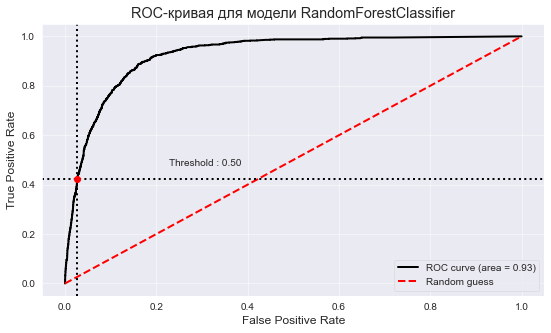

In [40]:
# Посмотрим на ROC-AUC в графическом представлении
bc = BinaryClassification(y_test, y_pred_prob_rf, labels=["Class 1"])
print('  -------------------------------------------------')
print('   Roc-Auc Score is: {:.3f}'.format(roc_auc_score(y_test, y_pred_prob_rf)))
print('  -------------------------------------------------')
plt.figure(figsize=(9,5))
bc.plot_roc_curve()
plt.title('ROC-кривая для модели RandomForestClassifier')
plt.show()

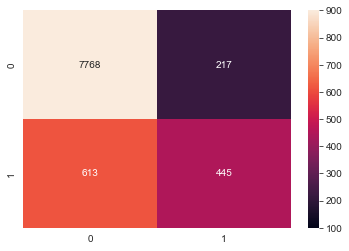

In [41]:
# Визуализируем матрицу ошибок построенной модели по классам
confusionMatrix = confusion_matrix(y_test,y_predictions_rf)
sns.heatmap(confusionMatrix,annot=True,fmt='d', vmin=100, vmax=900,);

In [42]:
# Выведем основные метрики через `Сlassification_report`
print('----------------------------------------------------------------------------')
print('Сlassification_report по основным метрикам для модели RandomForestClassifier:')
print('-----------------------------------------------------------------------------')
print(classification_report(y_test,y_predictions_rf))
print('-----------------------------------------------------------------------------')
F1Score_rf = f1_score(y_test, y_predictions_rf, average='micro') #it can be : binary,macro,weighted,samples
print('F1 Score Micro for RF model is : ', F1Score_rf.round(3))

----------------------------------------------------------------------------
Сlassification_report по основным метрикам для модели RandomForestClassifier:
-----------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7985
           1       0.67      0.42      0.52      1058

    accuracy                           0.91      9043
   macro avg       0.80      0.70      0.73      9043
weighted avg       0.90      0.91      0.90      9043

-----------------------------------------------------------------------------
F1 Score Micro for RF model is :  0.908


<a id="model5"></a>
### 2.5. Подбор параметров и тренировка модели DecisionTreeClassifier

In [43]:
#%%time
#model_dt = DecisionTreeClassifier(random_state=42,\
#                                  class_weight='balanced')
#                              
##scorer = make_scorer(accuracy_score)
#params = {'max_depth': [20,50,100],
#          'criterion'    : ['gini', 'entropy'],
#          'max_features': ['auto', 'sqrt', 'log2']
#          #'leaf_estimation_iterations': [4],
#          #'eval_metric': ['F1', 'AUC'] 
#          #'custom_metric' : ['TotalF1','Recall','Precision', 'AUC']
#         }
#grid = GridSearchCV(estimator=model_dt, param_grid = params,\
#                    return_train_score='warn',\
#                    cv = 5, n_jobs=-1, verbose =2, refit=True)
#grid.fit(X_train, y_train)
##, cat_features = cat_features)
#print(" Results from Grid Search ")
#print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
#print("\n The best score across ALL searched params:\n", grid.best_score_)
#print("\n The best parameters across ALL searched params:\n", grid.best_params_)    

#Results from Grid Search
#The best estimator across ALL searched params:
# DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
#                       max_depth=50, max_features='auto', random_state=42)
#
# The best score across ALL searched params:
# 0.8741702632326623
#
# The best parameters across ALL searched params:
# {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'auto'}
#CPU times: total: 297 ms
#Wall time: 1.35 s

In [44]:
model_dt = DecisionTreeClassifier(criterion = 'entropy', \
                                max_features= 'auto', max_depth=20,\
                                random_state=42) 
model_dt.fit(X_train, y_train)

#Calculating Details
print('DecisionTreeClassifier Train Score is : ' , model_dt.score(X_train, y_train).round(3))
print('DecisionTreeClassifier Test Score is : ' , model_dt.score(X_test, y_test).round(3))
#print('RandomForestClassifierModel features importances are : ' , model_rf.feature_importances_)
#Print('----------------------------------------------------')

DecisionTreeClassifier Train Score is :  0.975
DecisionTreeClassifier Test Score is :  0.885


In [45]:
y_predictions_dt = model_dt.predict(X_test)
y_pred_prob_dt = model_dt.predict_proba(X_test)[:,1]
print('Predicted Value for DecisionTreeClassifierModel is : ' , y_predictions_dt[:5])
print('Prediction Probabilities Value for DecisionTreeClassifierModel is : ' , y_pred_prob_dt[:5])
print('-------------------------------------------------------------------------------------')
print()
print("Accuracy score модели DecisionTreeClassifier на тестовой выборке: {:.2f}"\
      .format(accuracy_score(y_test, y_predictions_dt)))

Predicted Value for DecisionTreeClassifierModel is :  [0 0 0 0 0]
Prediction Probabilities Value for DecisionTreeClassifierModel is :  [0. 0. 0. 0. 0.]
-------------------------------------------------------------------------------------

Accuracy score модели DecisionTreeClassifier на тестовой выборке: 0.88


  -------------------------------------------------
   Roc-Auc Score is: 0.749
  -------------------------------------------------


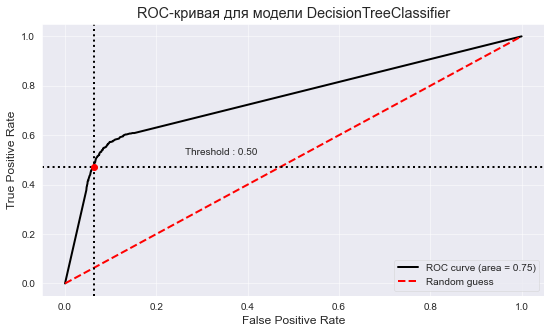

In [46]:
# Посмотрим на ROC-AUC в графическом представлении
bc = BinaryClassification(y_test, y_pred_prob_dt, labels=["Class 1"])
print('  -------------------------------------------------')
print('   Roc-Auc Score is: {:.3f}'.format(roc_auc_score(y_test, y_pred_prob_dt)))
print('  -------------------------------------------------')
plt.figure(figsize=(9,5))
bc.plot_roc_curve()
plt.title('ROC-кривая для модели DecisionTreeClassifier')
plt.show()

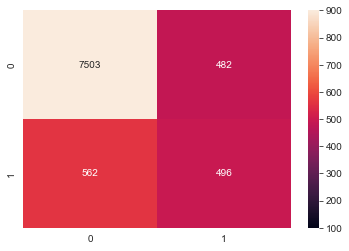

In [47]:
# Визуализируем матрицу ошибок построенной модели по классам
confusionMatrix = confusion_matrix(y_test,y_predictions_dt)
sns.heatmap(confusionMatrix,annot=True,fmt='d', vmin=100, vmax=900);

In [48]:
# Выведем основные метрики через `Сlassification_report`
print('----------------------------------------------------------------------------')
print('Сlassification_report по основным метрикам для модели DecisionTreeClassifier:')
print('-----------------------------------------------------------------------------')
print(classification_report(y_test,y_predictions_dt))

----------------------------------------------------------------------------
Сlassification_report по основным метрикам для модели DecisionTreeClassifier:
-----------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      7985
           1       0.51      0.47      0.49      1058

    accuracy                           0.88      9043
   macro avg       0.72      0.70      0.71      9043
weighted avg       0.88      0.88      0.88      9043



<a id="model6"></a>
### 2.6. Построение и тренировка модели Keras Sequential

In [49]:
n_features = X.shape[1]

In [50]:
model = Sequential()
model.add(Dense(20, input_shape=(n_features,), activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss= 'binary_crossentropy', optimizer = 'adam', 
              metrics = ['accuracy',])

In [51]:
# Сбалансируем классы через веса
class_weight = {0: 50.,
                1: 1.}

history = model.fit(X_train,y_train,
                   batch_size=32, epochs = 50,
                   validation_data = (X_test, y_test),
                   class_weight=class_weight, verbose = 1)

Epoch 1/50
1131/1131 [==============================] - 2s 2ms/step - loss: 2.7475 - accuracy: 0.8774 - val_loss: 0.8484 - val_accuracy: 0.8830
Epoch 2/50
1131/1131 [==============================] - 2s 1ms/step - loss: 1.1160 - accuracy: 0.8830 - val_loss: 0.7893 - val_accuracy: 0.8830
Epoch 3/50
1131/1131 [==============================] - 2s 1ms/step - loss: 1.0412 - accuracy: 0.8830 - val_loss: 0.7301 - val_accuracy: 0.8830
Epoch 4/50
1131/1131 [==============================] - 2s 2ms/step - loss: 0.9625 - accuracy: 0.8830 - val_loss: 0.6832 - val_accuracy: 0.8830
Epoch 5/50
1131/1131 [==============================] - 2s 2ms/step - loss: 0.8927 - accuracy: 0.8830 - val_loss: 0.6696 - val_accuracy: 0.8830
Epoch 6/50
1131/1131 [==============================] - 2s 1ms/step - loss: 0.8326 - accuracy: 0.8830 - val_loss: 0.6365 - val_accuracy: 0.8830
Epoch 7/50
1131/1131 [==============================] - 2s 1ms/step - loss: 0.7944 - accuracy: 0.8830 - val_loss: 0.6116 - val_accuracy:

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                340       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 561
Trainable params: 561
Non-trainable params: 0
_________________________________________________________________


283/283 [==============================] - 0s 973us/step
Accuracy:  0.883


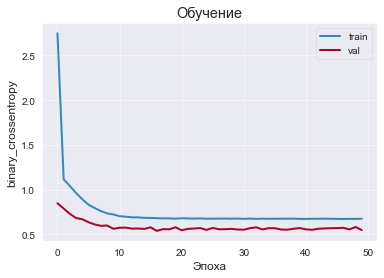

In [53]:
y_predict=model.predict(X_test) 
y_classes=np.argmax(y_predict,axis=1)
#yhat = model.predict_classes(X_test)

score = accuracy_score(y_test.array, y_classes)
print('Accuracy: ', score.round(4))

plt.title('Обучение')
plt.xlabel('Эпоха')
plt.ylabel('binary_crossentropy')

plt.plot(history.history['loss'],
        label = 'train')
plt.plot(history.history['val_loss'],
        label = 'val')
plt.legend();

  -------------------------------------------------
   Roc-Auc Score is: 0.893
  -------------------------------------------------


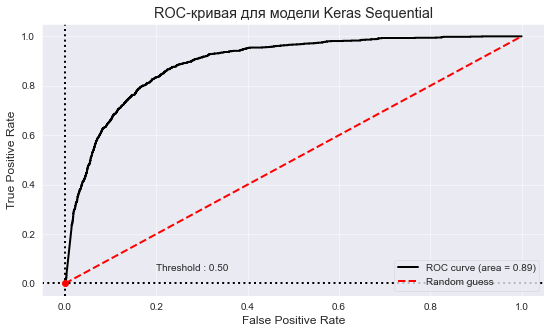

In [54]:
# Посмотрим на ROC-AUC в графическом представлении
bc = BinaryClassification(y_test, y_predict, labels=["Class 1"])
print('  -------------------------------------------------')
print('   Roc-Auc Score is: {:.3f}'.format(roc_auc_score(y_test, y_predict)))
print('  -------------------------------------------------')
plt.figure(figsize=(9,5))
bc.plot_roc_curve()
plt.title('ROC-кривая для модели Keras Sequential')
plt.show()

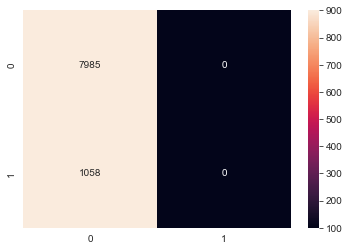

In [55]:
# Визуализируем матрицу ошибок построенной модели по классам
confusionMatrix = confusion_matrix(y_test,y_classes)
sns.heatmap(confusionMatrix,annot=True,fmt='d', vmin=100, vmax=900);

In [56]:
# Выведем основные метрики через `Сlassification_report`
print('----------------------------------------------------------------------------')
print('Сlassification_report по основным метрикам для модели Keras Sequential:')
print('-----------------------------------------------------------------------------')
print(classification_report(y_test,y_classes))

----------------------------------------------------------------------------
Сlassification_report по основным метрикам для модели Keras Sequential:
-----------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      7985
           1       0.00      0.00      0.00      1058

    accuracy                           0.88      9043
   macro avg       0.44      0.50      0.47      9043
weighted avg       0.78      0.88      0.83      9043



In [57]:
np.unique(y_classes)

array([0], dtype=int64)

<a id="model7"></a>
### 2.7. Построение и тренировка модели Keras Sequential with Cross-validation

Epoch 1/100
163/163 [==============================] - 1s 3ms/step - loss: 13.1231 - val_loss: 0.8323
Epoch 2/100
163/163 [==============================] - 0s 2ms/step - loss: 1.8449 - val_loss: 1.2890
Epoch 3/100
163/163 [==============================] - 0s 2ms/step - loss: 1.5578 - val_loss: 1.3055
Epoch 4/100
163/163 [==============================] - 0s 2ms/step - loss: 1.5149 - val_loss: 1.3185
Epoch 5/100
163/163 [==============================] - 0s 2ms/step - loss: 1.4420 - val_loss: 1.3041
Epoch 6/100
163/163 [==============================] - 0s 2ms/step - loss: 1.4333 - val_loss: 1.3331
Epoch 7/100
163/163 [==============================] - 0s 2ms/step - loss: 1.3398 - val_loss: 1.3928
Epoch 8/100
163/163 [==============================] - 0s 2ms/step - loss: 1.1616 - val_loss: 1.2927
Epoch 9/100
163/163 [==============================] - 0s 2ms/step - loss: 1.1185 - val_loss: 1.2697
Epoch 10/100
163/163 [==============================] - 0s 2ms/step - loss: 1.0835 - val_l

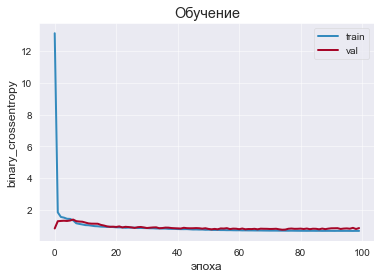

Epoch 1/100
163/163 [==============================] - 1s 3ms/step - loss: 10.2277 - val_loss: 0.7678
Epoch 2/100
163/163 [==============================] - 0s 2ms/step - loss: 1.3321 - val_loss: 0.8763
Epoch 3/100
163/163 [==============================] - 0s 2ms/step - loss: 1.2734 - val_loss: 0.8788
Epoch 4/100
163/163 [==============================] - 0s 2ms/step - loss: 1.2145 - val_loss: 0.8733
Epoch 5/100
163/163 [==============================] - 0s 2ms/step - loss: 1.1834 - val_loss: 0.8632
Epoch 6/100
163/163 [==============================] - 0s 2ms/step - loss: 1.1371 - val_loss: 0.8516
Epoch 7/100
163/163 [==============================] - 0s 2ms/step - loss: 1.0904 - val_loss: 0.8208
Epoch 8/100
163/163 [==============================] - 0s 2ms/step - loss: 1.0779 - val_loss: 0.8067
Epoch 9/100
163/163 [==============================] - 0s 3ms/step - loss: 1.0521 - val_loss: 0.8042
Epoch 10/100
163/163 [==============================] - 0s 3ms/step - loss: 1.0270 - val_l

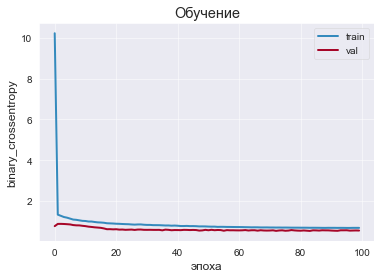

Epoch 1/100
163/163 [==============================] - 1s 3ms/step - loss: 9.4358 - val_loss: 0.8199
Epoch 2/100
163/163 [==============================] - 0s 2ms/step - loss: 1.4176 - val_loss: 1.0679
Epoch 3/100
163/163 [==============================] - 0s 2ms/step - loss: 1.2878 - val_loss: 1.0097
Epoch 4/100
163/163 [==============================] - 0s 2ms/step - loss: 1.2139 - val_loss: 0.9578
Epoch 5/100
163/163 [==============================] - 1s 3ms/step - loss: 1.1560 - val_loss: 0.9101
Epoch 6/100
163/163 [==============================] - 0s 3ms/step - loss: 1.1282 - val_loss: 0.8930
Epoch 7/100
163/163 [==============================] - 0s 3ms/step - loss: 1.0980 - val_loss: 0.8458
Epoch 8/100
163/163 [==============================] - 0s 3ms/step - loss: 1.0764 - val_loss: 0.8277
Epoch 9/100
163/163 [==============================] - 0s 2ms/step - loss: 1.0402 - val_loss: 0.8139
Epoch 10/100
163/163 [==============================] - 0s 2ms/step - loss: 1.0273 - val_lo

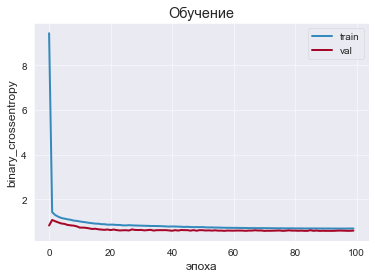

Epoch 1/100
163/163 [==============================] - 1s 3ms/step - loss: 11.5615 - val_loss: 0.6887
Epoch 2/100
163/163 [==============================] - 0s 3ms/step - loss: 1.6018 - val_loss: 1.0014
Epoch 3/100
163/163 [==============================] - 0s 3ms/step - loss: 1.3664 - val_loss: 0.9663
Epoch 4/100
163/163 [==============================] - 0s 3ms/step - loss: 1.2952 - val_loss: 0.9374
Epoch 5/100
163/163 [==============================] - 0s 2ms/step - loss: 1.2550 - val_loss: 0.9026
Epoch 6/100
163/163 [==============================] - 0s 2ms/step - loss: 1.1570 - val_loss: 0.8789
Epoch 7/100
163/163 [==============================] - 0s 2ms/step - loss: 1.1067 - val_loss: 0.8566
Epoch 8/100
163/163 [==============================] - 0s 2ms/step - loss: 1.0725 - val_loss: 0.8387
Epoch 9/100
163/163 [==============================] - 0s 2ms/step - loss: 1.0381 - val_loss: 0.8333
Epoch 10/100
163/163 [==============================] - 0s 2ms/step - loss: 1.0170 - val_l

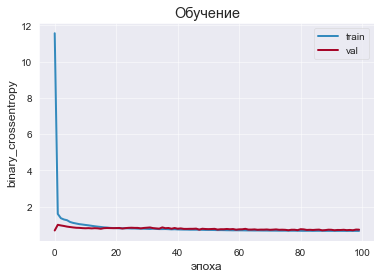

Epoch 1/100
163/163 [==============================] - 1s 3ms/step - loss: 7.5114 - val_loss: 0.8881
Epoch 2/100
163/163 [==============================] - 0s 2ms/step - loss: 1.2060 - val_loss: 0.9655
Epoch 3/100
163/163 [==============================] - 0s 2ms/step - loss: 1.1662 - val_loss: 0.9440
Epoch 4/100
163/163 [==============================] - 0s 2ms/step - loss: 1.1319 - val_loss: 0.9012
Epoch 5/100
163/163 [==============================] - 0s 2ms/step - loss: 1.0835 - val_loss: 0.8943
Epoch 6/100
163/163 [==============================] - 0s 2ms/step - loss: 1.0641 - val_loss: 0.8575
Epoch 7/100
163/163 [==============================] - 0s 2ms/step - loss: 1.0226 - val_loss: 0.8037
Epoch 8/100
163/163 [==============================] - 0s 2ms/step - loss: 0.9986 - val_loss: 0.7776
Epoch 9/100
163/163 [==============================] - 0s 2ms/step - loss: 0.9636 - val_loss: 0.7860
Epoch 10/100
163/163 [==============================] - 0s 3ms/step - loss: 0.9322 - val_lo

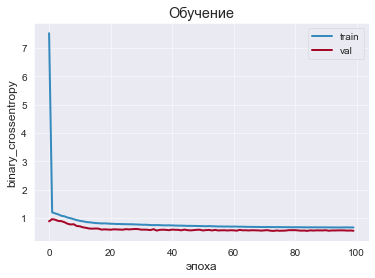

Epoch 1/100
163/163 [==============================] - 1s 3ms/step - loss: 8.7770 - val_loss: 0.7722
Epoch 2/100
163/163 [==============================] - 0s 2ms/step - loss: 1.3385 - val_loss: 0.9039
Epoch 3/100
163/163 [==============================] - 0s 2ms/step - loss: 1.2486 - val_loss: 0.8676
Epoch 4/100
163/163 [==============================] - 0s 3ms/step - loss: 1.1776 - val_loss: 0.8297
Epoch 5/100
163/163 [==============================] - 0s 3ms/step - loss: 1.1241 - val_loss: 0.7976
Epoch 6/100
163/163 [==============================] - 1s 3ms/step - loss: 1.0952 - val_loss: 0.7644
Epoch 7/100
163/163 [==============================] - 0s 3ms/step - loss: 1.0489 - val_loss: 0.7624
Epoch 8/100
163/163 [==============================] - 0s 3ms/step - loss: 1.0082 - val_loss: 0.7368
Epoch 9/100
163/163 [==============================] - 0s 2ms/step - loss: 0.9773 - val_loss: 0.7081
Epoch 10/100
163/163 [==============================] - 0s 2ms/step - loss: 0.9454 - val_lo

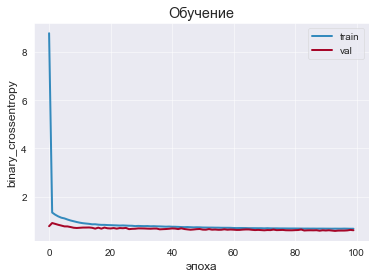

Epoch 1/100
163/163 [==============================] - 1s 3ms/step - loss: 8.5307 - val_loss: 0.8536
Epoch 2/100
163/163 [==============================] - 0s 3ms/step - loss: 1.3903 - val_loss: 1.0043
Epoch 3/100
163/163 [==============================] - 0s 2ms/step - loss: 1.2793 - val_loss: 0.9360
Epoch 4/100
163/163 [==============================] - 0s 2ms/step - loss: 1.2000 - val_loss: 0.8776
Epoch 5/100
163/163 [==============================] - 0s 3ms/step - loss: 1.1509 - val_loss: 0.8386
Epoch 6/100
163/163 [==============================] - 0s 3ms/step - loss: 1.1053 - val_loss: 0.8063
Epoch 7/100
163/163 [==============================] - 0s 2ms/step - loss: 1.0864 - val_loss: 0.7781
Epoch 8/100
163/163 [==============================] - 0s 2ms/step - loss: 1.0454 - val_loss: 0.7652
Epoch 9/100
163/163 [==============================] - 0s 2ms/step - loss: 1.0046 - val_loss: 0.7325
Epoch 10/100
163/163 [==============================] - 0s 3ms/step - loss: 0.9732 - val_lo

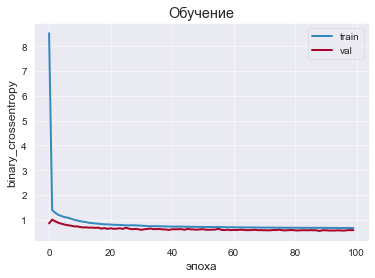

Epoch 1/100
163/163 [==============================] - 1s 3ms/step - loss: 8.8550 - val_loss: 0.7497
Epoch 2/100
163/163 [==============================] - 0s 2ms/step - loss: 1.3181 - val_loss: 0.8637
Epoch 3/100
163/163 [==============================] - 0s 2ms/step - loss: 1.2412 - val_loss: 0.8187
Epoch 4/100
163/163 [==============================] - 0s 2ms/step - loss: 1.1755 - val_loss: 0.7799
Epoch 5/100
163/163 [==============================] - 0s 2ms/step - loss: 1.1178 - val_loss: 0.7518
Epoch 6/100
163/163 [==============================] - 0s 2ms/step - loss: 1.0674 - val_loss: 0.7354
Epoch 7/100
163/163 [==============================] - 0s 2ms/step - loss: 1.0319 - val_loss: 0.7328
Epoch 8/100
163/163 [==============================] - 0s 3ms/step - loss: 0.9877 - val_loss: 0.7271
Epoch 9/100
163/163 [==============================] - 0s 3ms/step - loss: 0.9582 - val_loss: 0.6883
Epoch 10/100
163/163 [==============================] - 0s 3ms/step - loss: 0.9251 - val_lo

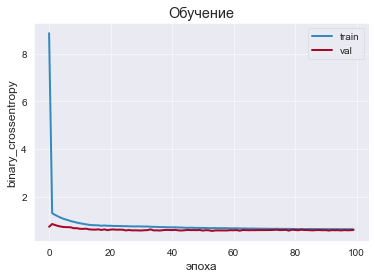

Epoch 1/100
163/163 [==============================] - 1s 3ms/step - loss: 14.6802 - val_loss: 0.6548
Epoch 2/100
163/163 [==============================] - 0s 2ms/step - loss: 1.7527 - val_loss: 1.0034
Epoch 3/100
163/163 [==============================] - 0s 2ms/step - loss: 1.5078 - val_loss: 0.9947
Epoch 4/100
163/163 [==============================] - 0s 2ms/step - loss: 1.4361 - val_loss: 0.9464
Epoch 5/100
163/163 [==============================] - 0s 2ms/step - loss: 1.3629 - val_loss: 0.8995
Epoch 6/100
163/163 [==============================] - 0s 2ms/step - loss: 1.2996 - val_loss: 0.8663
Epoch 7/100
163/163 [==============================] - 0s 2ms/step - loss: 1.2528 - val_loss: 0.8077
Epoch 8/100
163/163 [==============================] - 0s 2ms/step - loss: 1.1993 - val_loss: 0.7830
Epoch 9/100
163/163 [==============================] - 0s 2ms/step - loss: 1.1795 - val_loss: 0.7391
Epoch 10/100
163/163 [==============================] - 0s 2ms/step - loss: 1.1277 - val_l

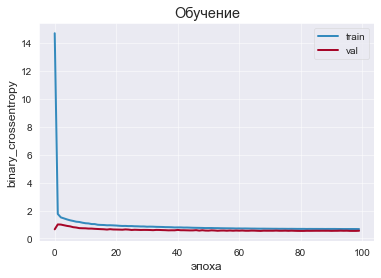

Epoch 1/100
163/163 [==============================] - 1s 4ms/step - loss: 7.3050 - val_loss: 0.8078
Epoch 2/100
163/163 [==============================] - 0s 3ms/step - loss: 1.3809 - val_loss: 0.9322
Epoch 3/100
163/163 [==============================] - 0s 2ms/step - loss: 1.2664 - val_loss: 0.8723
Epoch 4/100
163/163 [==============================] - 0s 2ms/step - loss: 1.2123 - val_loss: 0.8199
Epoch 5/100
163/163 [==============================] - 0s 2ms/step - loss: 1.1631 - val_loss: 0.7767
Epoch 6/100
163/163 [==============================] - 0s 2ms/step - loss: 1.1164 - val_loss: 0.7560
Epoch 7/100
163/163 [==============================] - 0s 2ms/step - loss: 1.0930 - val_loss: 0.7326
Epoch 8/100
163/163 [==============================] - 0s 3ms/step - loss: 1.0715 - val_loss: 0.7055
Epoch 9/100
163/163 [==============================] - 0s 3ms/step - loss: 1.0456 - val_loss: 0.6832
Epoch 10/100
163/163 [==============================] - 0s 3ms/step - loss: 1.0171 - val_lo

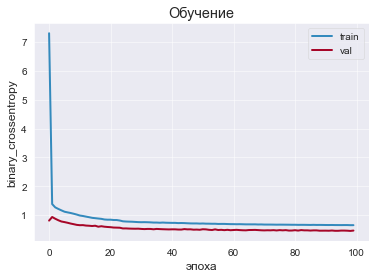

In [58]:
#kfold = StratifiedKFold(10)
kfold = StratifiedKFold(10)
scores_cv = []

for train_ix, test_ix in kfold.split(X,y):
    X_train, X_test, y_train, y_test = X[train_ix], X[test_ix], y[train_ix], y[test_ix]
    n_features = X.shape[1]    
    


    model_cv = Sequential()
    model_cv.add(Dense(20, input_shape=(n_features,), activation = 'relu'))
    model_cv.add(Dropout(0.3))
    model_cv.add(Dense(20, activation = 'relu'))
    model_cv.add(Dropout(0.3))
    model_cv.add(Dense(10, activation = 'relu'))
    model_cv.add(Dropout(0.2))
    model_cv.add(Dense(1, activation = 'sigmoid'))

    model_cv.compile(loss= 'binary_crossentropy', optimizer = 'adam')

    history = model_cv.fit(X_train,y_train,
                       batch_size=250, epochs = 100,
                       validation_data = (X_test, y_test),
                       class_weight=class_weight, verbose = 1)
    y_predict_cv = model_cv.predict(X_test) 
    y_classes_cv = np.argmax(y_predict_cv,axis=1)
    #y_pred = model.predict_classes(X_test)
    
    score_cv = accuracy_score(y_test, y_classes_cv)
    print('Accuracy: ', score_cv)

    plt.title('Обучение')
    plt.xlabel('эпоха')
    plt.ylabel('binary_crossentropy')

    plt.plot(history.history['loss'],
            label = 'train')
    plt.plot(history.history['val_loss'],
            label = 'val')
    plt.legend()
    plt.show()
    
    scores_cv.append(score_cv)


In [59]:
print('Средняя точность при Cross_validation: ', np.mean(scores_cv).round(3))

Средняя точность при Cross_validation:  0.883


In [60]:
model_cv.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 20)                340       
                                                                 
 dropout_29 (Dropout)        (None, 20)                0         
                                                                 
 dense_40 (Dense)            (None, 20)                420       
                                                                 
 dropout_30 (Dropout)        (None, 20)                0         
                                                                 
 dense_41 (Dense)            (None, 10)                210       
                                                                 
 dropout_31 (Dropout)        (None, 10)                0         
                                                                 
 dense_42 (Dense)            (None, 1)               

  -------------------------------------------------
   Roc-Auc Score is: 0.811
  -------------------------------------------------


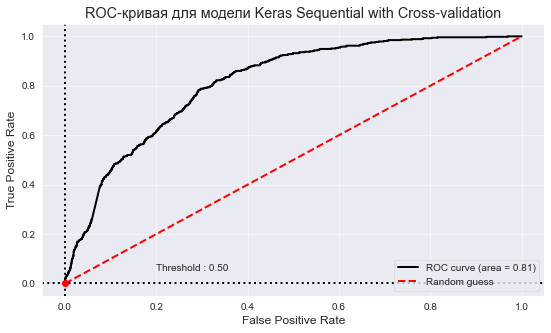

In [61]:
# Посмотрим на ROC-AUC в графическом представлении
bc = BinaryClassification(y_test, y_predict_cv, labels=["Class 1"])
print('  -------------------------------------------------')
print('   Roc-Auc Score is: {:.3f}'.format(roc_auc_score(y_test, y_predict_cv)))
print('  -------------------------------------------------')
plt.figure(figsize=(9,5))
bc.plot_roc_curve()
plt.title('ROC-кривая для модели Keras Sequential with Cross-validation')
plt.show()

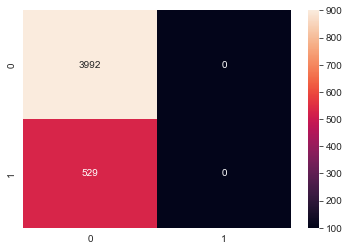

In [62]:
# Визуализируем матрицу ошибок построенной модели по классам
confusionMatrix = confusion_matrix(y_test,y_classes_cv)
sns.heatmap(confusionMatrix,annot=True,fmt='d', vmin=100, vmax=900);

In [63]:
# Выведем основные метрики через `Сlassification_report`
print('----------------------------------------------------------------------------')
print('Сlassification_report по основным метрикам для модели Keras Sequential with Cross-validation:')
print('-----------------------------------------------------------------------------')
print(classification_report(y_test,y_classes_cv))

----------------------------------------------------------------------------
Сlassification_report по основным метрикам для модели Keras Sequential with Cross-validation:
-----------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      3992
           1       0.00      0.00      0.00       529

    accuracy                           0.88      4521
   macro avg       0.44      0.50      0.47      4521
weighted avg       0.78      0.88      0.83      4521



<a id="conclusion"></a>
## 3. Выводы и сохранение лучшей модели 

In [64]:
models = {'ROC-AUC': pd.Series([0.94, 0.93, 0.75, 0.89, roc_auc_score(y_test, y_predict_cv).round(2)],
                      index=['CatboostClassifier', 'RandomForestClassifier', 'DecisionTreeClassifier',\
                             'Keras Sequential', 'Keras Sequential with Cross-validation']),\
         'Accuracy': pd.Series([0.90, 0.91, 0.88, 0.88, accuracy_score(y_test, y_classes_cv).round(2)],
                      index=['CatboostClassifier', 'RandomForestClassifier', 'DecisionTreeClassifier',\
                             'Keras Sequential', 'Keras Sequential with Cross-validation']),\
         'F1 (1 class)': pd.Series([0.64, 0.52, 0.49, 0,0],
                      index=['CatboostClassifier', 'RandomForestClassifier', 'DecisionTreeClassifier',\
                             'Keras Sequential', 'Keras Sequential with Cross-validation']),\
         'F1 weighted': pd.Series([0.91, 0.90, 0.88, 0.83, 0.83],
                      index=['CatboostClassifier', 'RandomForestClassifier', 'DecisionTreeClassifier',\
                             'Keras Sequential', 'Keras Sequential with Cross-validation'])}
models = pd.DataFrame(models)
models.sort_values(
   by=['ROC-AUC', 'F1 weighted'], ascending=False)

,ROC-AUC,Accuracy,F1 (1 class),F1 weighted
CatboostClassifier,0.94,0.90,0.64,0.91
RandomForestClassifier,0.93,0.91,0.52,0.90
Keras Sequential,0.89,0.88,0.00,0.83
Keras Sequential with Cross-validation,0.81,0.88,0.00,0.83
DecisionTreeClassifier,0.75,0.88,0.49,0.88


* Если принимать решение по метрике ROC-AUC, то лучшими моделями будут CatboostClassifier (0,94) и RandomForestClassifier (0,93)
* Если принимать решение по метрике F1 (для предсказания именно 1 класса или взвешенного), то лучшими моделями также будут CatboostClassifier и RandomForestClassifier, но CatboostClassifier показывает значительно лучшие результаты
* К сожалению, нейросети (и простая сеть и с применение cross/validation) не предсказывают 1 класс вообще, хотя по 0 классу точность высокая. Причина такого предсказания 1 класса в данных (дисбаланс классов) и балансировка через веса классов не улучшила ситуацию. 
* С учетом минимального обхема ручной обраюотки данных, требуемых для построения модели, безусловно побеждает CatboostClassifier, который самостоятельно обрабатывает категориальные данные, а также хорошо справляется с автоматической балансировкой дисбаланса классов.
* Эту модель мы сохраним и сможем испольщовать для предсказаний
* Для возможного дальнейшего применения также предлагается сохранить и модель RandomForestClassifier

In [65]:
with open('model_cb.pkl', 'wb') as f:
    pickle.dump(model_cb, f)

In [66]:
with open('model_rf.pkl', 'wb') as f:
    pickle.dump(model_rf, f)

In [67]:
!pip freeze > requirements.txt